In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from scipy.stats import spearmanr
import ast
from scipy.stats import kstest

In [2]:
out = r"C:\Users\Maciek\Documents\Studia\Magisterka\Images"
model_name = "LSTM"

In [3]:
# Method used to decode filename of model into balancing method, imbalance %, model name, and model id returned in an array
def get_method_and_percentage(name):
    string = "_".join(name.split("_")[:-1])
    percentage = ""
    perc = 0
    for i in range(len(string)):
        if string[i].isdigit():
            perc = i
            percentage += string[i]
        elif perc>0:
            break
    perc+=2 if len(percentage)>0 else 0
    method = ""
    for i in range(perc, len(string)):
        if string[i].isdigit():
            model_id = string[i]
        else:
            method += string[i]
    method = "_".join(method.split("_")[:-1])
    model = name.split("_")[-1][:-4]
    return [method, percentage, model, model_id]



df = pd.read_csv(r"C:\Users\Maciek\Documents\Studia\Magisterka\GitHub\BalancingMethodsNLP\Results\XAI_results_final_SVM.csv")
# for i in range(2,5):
#     df = pd.concat([df, pd.read_csv(f"XAI_results{i}.csv")])
pd.set_option('display.width', 1000)


name = pd.DataFrame(list(df["model"].map(lambda x:get_method_and_percentage(x))))
name.columns = ["Balancing method", "Imbalance %", "Model name", "Model ID"]
df = pd.concat([name, df[df.columns[2:]]], axis=1)
df = df.sort_values(["id", "Imbalance %", "Model ID", "Balancing method", "Model name"])
df.columns = [str(col).replace("eval_", "") for col in df.columns]
df


,Balancing method,Imbalance %,Model name,Model ID,model,id,words_sentence,lime_sentence,words_word,lime_word
2360,LLama,10,SVM,0,erqaser_movie_10_LLama_0_SVM.obj,0,"['there', 'may', 'not', 'be', 'a', 'critic', '...","[-0.022934971744675903, -0.0011958517663429719...",['a' 'about' 'accidental' 'act' 'action' 'affe...,"[4.33616739313076e-05, -0.003697329228902472, ..."
240,LLama_complex,10,SVM,0,erqaser_movie_10_LLama_complex_0_SVM.obj,0,"['there', 'may', 'not', 'be', 'a', 'critic', '...","[-0.025988159852367843, 6.581122178263225e-05,...",['a' 'about' 'accidental' 'act' 'action' 'affe...,"[0.0014720104444310655, -0.0034905926641814796..."
4280,Spelling_mistake,10,SVM,0,eraser_movie_10_Spelling_mistake_0_SVM.obj,0,"['there', 'may', 'not', 'be', 'a', 'critic', '...","[-0.0011810498143123476, 0.0005604996632146234...",['a' 'about' 'accidental' 'act' 'action' 'affe...,"[1.8490600872828456e-06, 0.00063961701514308, ..."
4720,Summarization,10,SVM,0,eraser_movie_10_Summarization_0_SVM.obj,0,"['there', 'may', 'not', 'be', 'a', 'critic', '...","[-0.02302369617100015, 0.005382751226700691, -...",['a' 'about' 'accidental' 'act' 'action' 'affe...,"[-0.00728526808831889, -0.007228939307951602, ..."
1200,imbalanced,10,SVM,0,eraser_movie_10_imbalanced_0_SVM.obj,0,"['there', 'may', 'not', 'be', 'a', 'critic', '...","[-0.0025273509423874344, 0.0014477108266709824...",['a' 'about' 'accidental' 'act' 'action' 'affe...,"[-0.00017893744925643828, 0.000100026422368737..."
...,...,...,...,...,...,...,...,...,...,...
1879,Summarization,50,SVM,4,eraser_movie_50_Summarization_4_SVM.obj,39,"['post', 'chasing', 'amy', 'a', 'slew', 'of', ...","[-0.006673409508617923, -0.003302518305947108,...",['a' 'about' 'absolutely' 'actress' 'affection...,"[0.007313659886995239, -0.03943056670312839, 0..."
2839,Synonym replacement,50,SVM,4,eraser_movie_50_Synonym replacement_4_SVM.obj,39,"['post', 'chasing', 'amy', 'a', 'slew', 'of', ...","[-0.002011967401941093, 0.003023487946904732, ...",['a' 'about' 'absolutely' 'actress' 'affection...,"[0.001734781503550134, -0.022458994400458576, ..."
2799,Translation,50,SVM,4,eraser_movie_50_Translation_4_SVM.obj,39,"['post', 'chasing', 'amy', 'a', 'slew', 'of', ...","[-0.006630525803076841, -0.0011548571634200369...",['a' 'about' 'absolutely' 'actress' 'affection...,"[0.007536974074509293, -0.03649603137169283, 0..."
1679,imbalanced,50,SVM,4,eraser_movie_50_imbalanced_4_SVM.obj,39,"['post', 'chasing', 'amy', 'a', 'slew', 'of', ...","[-0.005686366598732487, -0.0012348522757685751...",['a' 'about' 'absolutely' 'actress' 'affection...,"[-0.0025714797093108065, -0.01913111031902743,..."


In [4]:
df_tm = df
df_tm["test"]=df["words_sentence"].apply(lambda x:len(ast.literal_eval(x)))
df_tm.sort_values(["test"])

,Balancing method,Imbalance %,Model name,Model ID,model,id,words_sentence,lime_sentence,words_word,lime_word,test
4404,Contextual_word_embedding,20,SVM,3,eraser_movie_20_Contextual_word_embedding_3_SV...,4,"['it', 's', 'a', 'good', 'thing', 'most', 'ani...","[0.0007959617447798443, 0.0020299677295080856,...",['31st' 'a' 'about' 'action' 'aliens' 'all' 'a...,"[-0.0010892373022123405, -0.000835496877823641...",227
4084,imbalanced,10,SVM,4,eraser_movie_10_imbalanced_4_SVM.obj,4,"['it', 's', 'a', 'good', 'thing', 'most', 'ani...","[0.0219913907236966, -0.002384102631966567, -0...",['31st' 'a' 'about' 'action' 'aliens' 'all' 'a...,"[-0.0010565311733117865, -0.000749771898342483...",227
3244,paraphrase,10,SVM,4,eraser_movie_10_paraphrase_4_SVM.obj,4,"['it', 's', 'a', 'good', 'thing', 'most', 'ani...","[0.02387480022857906, -3.889418483192268e-05, ...",['31st' 'a' 'about' 'action' 'aliens' 'all' 'a...,"[0.001749679995380933, 0.0024248918058866987, ...",227
1364,original,100,SVM,0,eraser_movie_100_original_0_SVM.obj,4,"['it', 's', 'a', 'good', 'thing', 'most', 'ani...","[0.011368173308051276, -0.0025109179562329475,...",['31st' 'a' 'about' 'action' 'aliens' 'all' 'a...,"[-0.009330320474047435, 0.001892767688430766, ...",227
5004,Contextual_word_embedding,20,SVM,0,eraser_movie_20_Contextual_word_embedding_0_SV...,4,"['it', 's', 'a', 'good', 'thing', 'most', 'ani...","[-0.0011038233885993646, -0.000557758229689116...",['31st' 'a' 'about' 'action' 'aliens' 'all' 'a...,"[-7.331770101630553e-05, -0.001306844707829482...",227
...,...,...,...,...,...,...,...,...,...,...,...
1826,LLama_complex,50,SVM,1,erqaser_movie_50_LLama_complex_1_SVM.obj,26,"['star', 'wars', 'episode', 'i', 'the', 'phant...","[0.017687691314091352, 0.038926594111038736, 0...",['131' '1999' '20th' 'a' 'about' 'abysmally' '...,"[-0.0012643835727322032, 0.009877815486696626,...",1503
1146,ROS,50,SVM,1,eraser_movie_50_ROS_1_SVM.obj,26,"['star', 'wars', 'episode', 'i', 'the', 'phant...","[0.03896201379462929, 0.07490304692075408, -0....",['131' '1999' '20th' 'a' 'about' 'abysmally' '...,"[0.0047734452502470985, 0.009680083847964874, ...",1503
2866,Summarization,50,SVM,1,eraser_movie_50_Summarization_1_SVM.obj,26,"['star', 'wars', 'episode', 'i', 'the', 'phant...","[0.029764674724223183, 0.07310628199316749, 0....",['131' '1999' '20th' 'a' 'about' 'abysmally' '...,"[-0.009224182307176752, 0.01451632752993455, -...",1503
1266,Contextual_word_embedding,50,SVM,0,eraser_movie_50_Contextual_word_embedding_0_SV...,26,"['star', 'wars', 'episode', 'i', 'the', 'phant...","[0.027139195629615497, 0.022115357860027947, -...",['131' '1999' '20th' 'a' 'about' 'abysmally' '...,"[-0.004375305448444561, 0.0044451596176798315,...",1503


_________________ original _________________
it s a good thing most animated sci fi movies come from japan because titan a e is proof that hollywood does n t have a clue 
how to do it i do n t know what this film is supposed to be about from what i can tell it s about a young man named kale who s one of the 
last survivors of earth in the early 31st century who unknowingly possesses the key to saving and re generating what is left 
of the human race that s a fine premise for an action packed sci fi animated movie but there s no payoff the story takes the 
main characters all over the galaxy in their search for a legendary ship that the evil dredge aliens want to destroy for no 
apparent reason so in the process we get a lot of spaceship fights fistfights blaster fights and more double crosses than you can 
shake a stick at there s so much pointless sci fi banterit s too much to take the galaxy here is a total rip off of the star wars 
universe the creators do n t bother filling in the 

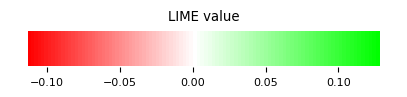

_________________ Contextual_word_embedding _________________
it s a good thing most animated sci fi movies come from japan because titan a e is proof that hollywood does n t have a clue 
how to do it i do n t know what this film is supposed to be about from what i can tell it s about a young man named kale who s one of the 
last survivors of earth in the early 31st century who unknowingly possesses the key to saving and re generating what is left 
of the human race that s a fine premise for an action packed sci fi animated movie but there s no payoff the story takes the 
main characters all over the galaxy in their search for a legendary ship that the evil dredge aliens want to destroy for no 
apparent reason so in the process we get a lot of spaceship fights fistfights blaster fights and more double crosses than you can 
shake a stick at there s so much pointless sci fi banterit s too much to take the galaxy here is a total rip off of the star wars 
universe the creators do n t bothe

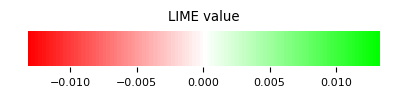

_________________ LLama_complex _________________
it s a good thing most animated sci fi movies come from japan because titan a e is proof that hollywood does n t have a clue 
how to do it i do n t know what this film is supposed to be about from what i can tell it s about a young man named kale who s one of the 
last survivors of earth in the early 31st century who unknowingly possesses the key to saving and re generating what is left 
of the human race that s a fine premise for an action packed sci fi animated movie but there s no payoff the story takes the 
main characters all over the galaxy in their search for a legendary ship that the evil dredge aliens want to destroy for no 
apparent reason so in the process we get a lot of spaceship fights fistfights blaster fights and more double crosses than you can 
shake a stick at there s so much pointless sci fi banterit s too much to take the galaxy here is a total rip off of the star wars 
universe the creators do n t bother filling in

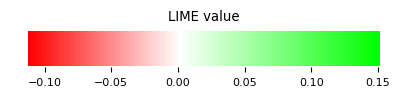

_________________ ROS _________________
it s a good thing most animated sci fi movies come from japan because titan a e is proof that hollywood does n t have a clue 
how to do it i do n t know what this film is supposed to be about from what i can tell it s about a young man named kale who s one of the 
last survivors of earth in the early 31st century who unknowingly possesses the key to saving and re generating what is left 
of the human race that s a fine premise for an action packed sci fi animated movie but there s no payoff the story takes the 
main characters all over the galaxy in their search for a legendary ship that the evil dredge aliens want to destroy for no 
apparent reason so in the process we get a lot of spaceship fights fistfights blaster fights and more double crosses than you can 
shake a stick at there s so much pointless sci fi banterit s too much to take the galaxy here is a total rip off of the star wars 
universe the creators do n t bother filling in the basic

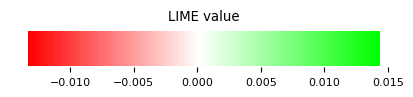

_________________ Spelling_mistake _________________
it s a good thing most animated sci fi movies come from japan because titan a e is proof that hollywood does n t have a clue 
how to do it i do n t know what this film is supposed to be about from what i can tell it s about a young man named kale who s one of the 
last survivors of earth in the early 31st century who unknowingly possesses the key to saving and re generating what is left 
of the human race that s a fine premise for an action packed sci fi animated movie but there s no payoff the story takes the 
main characters all over the galaxy in their search for a legendary ship that the evil dredge aliens want to destroy for no 
apparent reason so in the process we get a lot of spaceship fights fistfights blaster fights and more double crosses than you can 
shake a stick at there s so much pointless sci fi banterit s too much to take the galaxy here is a total rip off of the star wars 
universe the creators do n t bother filling

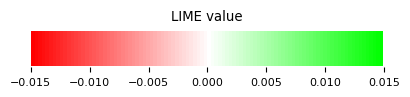

_________________ Summarization _________________
it s a good thing most animated sci fi movies come from japan because titan a e is proof that hollywood does n t have a clue 
how to do it i do n t know what this film is supposed to be about from what i can tell it s about a young man named kale who s one of the 
last survivors of earth in the early 31st century who unknowingly possesses the key to saving and re generating what is left 
of the human race that s a fine premise for an action packed sci fi animated movie but there s no payoff the story takes the 
main characters all over the galaxy in their search for a legendary ship that the evil dredge aliens want to destroy for no 
apparent reason so in the process we get a lot of spaceship fights fistfights blaster fights and more double crosses than you can 
shake a stick at there s so much pointless sci fi banterit s too much to take the galaxy here is a total rip off of the star wars 
universe the creators do n t bother filling in

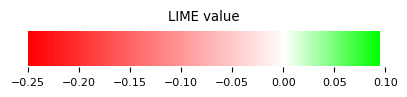

_________________ Synonym replacement _________________
it s a good thing most animated sci fi movies come from japan because titan a e is proof that hollywood does n t have a clue 
how to do it i do n t know what this film is supposed to be about from what i can tell it s about a young man named kale who s one of the 
last survivors of earth in the early 31st century who unknowingly possesses the key to saving and re generating what is left 
of the human race that s a fine premise for an action packed sci fi animated movie but there s no payoff the story takes the 
main characters all over the galaxy in their search for a legendary ship that the evil dredge aliens want to destroy for no 
apparent reason so in the process we get a lot of spaceship fights fistfights blaster fights and more double crosses than you can 
shake a stick at there s so much pointless sci fi banterit s too much to take the galaxy here is a total rip off of the star wars 
universe the creators do n t bother fill

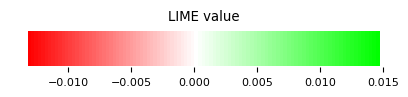

_________________ imbalanced _________________
it s a good thing most animated sci fi movies come from japan because titan a e is proof that hollywood does n t have a clue 
how to do it i do n t know what this film is supposed to be about from what i can tell it s about a young man named kale who s one of the 
last survivors of earth in the early 31st century who unknowingly possesses the key to saving and re generating what is left 
of the human race that s a fine premise for an action packed sci fi animated movie but there s no payoff the story takes the 
main characters all over the galaxy in their search for a legendary ship that the evil dredge aliens want to destroy for no 
apparent reason so in the process we get a lot of spaceship fights fistfights blaster fights and more double crosses than you can 
shake a stick at there s so much pointless sci fi banterit s too much to take the galaxy here is a total rip off of the star wars 
universe the creators do n t bother filling in th

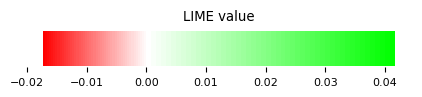

_________________ paraphrase _________________
it s a good thing most animated sci fi movies come from japan because titan a e is proof that hollywood does n t have a clue 
how to do it i do n t know what this film is supposed to be about from what i can tell it s about a young man named kale who s one of the 
last survivors of earth in the early 31st century who unknowingly possesses the key to saving and re generating what is left 
of the human race that s a fine premise for an action packed sci fi animated movie but there s no payoff the story takes the 
main characters all over the galaxy in their search for a legendary ship that the evil dredge aliens want to destroy for no 
apparent reason so in the process we get a lot of spaceship fights fistfights blaster fights and more double crosses than you can 
shake a stick at there s so much pointless sci fi banterit s too much to take the galaxy here is a total rip off of the star wars 
universe the creators do n t bother filling in th

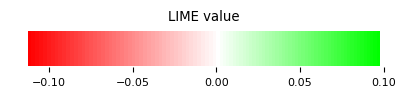

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)  
def color_output(words, explanations):
    coloring_range = ( np.min(explanations), np.max(explanations))
    l=0
    for j in range(len(words)):
        if explanations[j]<0:
            perc = explanations[j]/coloring_range[0]
            r, g, b = 255,int(-255*perc+255),int(-255*perc+255)
        else:
            perc = explanations[j]/coloring_range[1]
            r, g, b = int(-255*perc+255),255,int(-255*perc+255)
        l+=len(words[j])
        if l>100:
            print("\n",end="")
            l=0
        print(f'\033[38;2;{r};{g};{b}m\033[48;2;0;0;0m{words[j]} \033[0m', end="") 
    
    n = 50
    lin_1 = np.linspace(coloring_range[0],0,n)
    diff_1 = lin_1[1]-lin_1[0]
    lin_2 = np.linspace(0, coloring_range[1],n)
    diff_2 = lin_2[1]-lin_2[0]
    # plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(5,1/2))
    plt.plot()

    for i in range(n):
        perc = (lin_1[0]-lin_1[i])/coloring_range[0]
        rect = patches.Rectangle((coloring_range[0]-lin_1[i], 0), diff_1, 1, facecolor=(1,int(-255*perc+255)/255,int(-255*perc+255)/255))
        ax.add_patch(rect)
        perc = (lin_2[i])/coloring_range[1]
        rect = patches.Rectangle((lin_2[i], 0), diff_2, 1, facecolor=(int(-255*perc+255)/255,1,int(-255*perc+255)/255))
        ax.add_patch(rect)
    ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.title("LIME value")
    plt.show()
    
df_tmp = df[(df["id"]==4)&((df["Imbalance %"].astype(int)==20)| (df["Imbalance %"].astype(int)==100))&(df["Model ID"].astype(int)==0)&(df["Balancing method"]!="LLama")]
for val in df_tmp.values:
    print(f"_________________ {val[0]} _________________")      
    color_output(ast.literal_eval(val[6]), ast.literal_eval(val[7]))

In [6]:
# Method used to calculate p_values from wilcoxon-signed rank test between two explanations
def get_p_values(df, lime="lime_sentence"):
    results = []
    
    # Selecting model trained on original data for comparison
    original = df[df["Balancing method"]=="original"]

    # Looping through imbalance % model id balancing method and instances
    for imbalance in np.unique(df["Imbalance %"]):
        for model_id in np.unique(df["Model ID"]):
            # Selecting model trained on imbalanced data for comparison
            df_tmp = df[(df["Imbalance %"]==imbalance)&(df["Model ID"]==model_id)&(df["Balancing method"]!="original")]
            imbalanced = df_tmp[df_tmp["Balancing method"]=="imbalanced"]
            # Filtering models based on balanced datasets
            other_methods = df_tmp[df_tmp["Balancing method"]!="imbalanced"]
            for method in np.unique(other_methods["Balancing method"]):
                for i in np.unique(other_methods.id)[:2]:
                    # Saving basic model identification
                    res = {}
                    res["Model ID"] = model_id
                    res["Imbalance %"] = imbalance
                    res["Balancing method"] = method
                    res["id"] = i
                    # Comparing xai from original model and xai from balanced model
                    df_tmp = other_methods[other_methods["Balancing method"]==method]
                    x1 = ast.literal_eval(df_tmp[df_tmp.id==i][lime].values[0])
                    x2 = ast.literal_eval(original[original.id==i][lime].values[0])
                    res["original"] = stats.wilcoxon(x1, x2)[1]
                    res["spearman_original"] = spearmanr(x1, x2)[0]
                    res["normality_original"] = kstest(np.array(x1)-np.array(x2), 'norm')[1]
                    # Comparing xai from imbalanced model and xai from balanced model if imbalanced model was not bad (acc>0.6 & f1!=0)
                    if len(imbalanced)>0:
                        x3 = ast.literal_eval(imbalanced[imbalanced.id==i][lime].values[0])
                        res["imbalanced"] = stats.wilcoxon(x1, x3)[1]
                        res["spearman_imbalanced"] = spearmanr(x1, x3)[0]
                        res["normality_imbalanced"] = kstest(np.array(x1)-np.array(x2), 'norm')[1]
                    results.append(res)
    return pd.DataFrame(results)

results_sentence = get_p_values(df, lime="lime_sentence")
results_word = get_p_values(df, lime="lime_word")
results_sentence.head().round(4)

,Model ID,Imbalance %,Balancing method,id,original,spearman_original,normality_original,imbalanced,spearman_imbalanced,normality_imbalanced
0,0,10,LLama,0,0.0000,0.5023,0.0,0.0000,0.5983,0.0
1,0,10,LLama,1,0.0030,0.5951,0.0,0.0000,0.3507,0.0
2,0,10,LLama_complex,0,0.0001,0.5165,0.0,0.0000,0.5909,0.0
3,0,10,LLama_complex,1,0.0078,0.5391,0.0,0.0000,0.2461,0.0
4,0,10,Spelling_mistake,0,0.8859,0.2773,0.0,0.9193,0.4211,0.0


In [7]:
# Method used to join results and metrics tables
def add_metrics(results, metrics):
    
    # Changing column types to get agreement between tables
    results['Model ID'] = results['Model ID'].astype(str)
    metrics['Model ID'] = metrics['Model ID'].astype(str)
    results['Imbalance %'] = results['Imbalance %'].astype(str)
    metrics['Imbalance %'] = metrics['Imbalance %'].astype(str)
    
    # Merging tables
    final = results.merge(metrics, on=['Model ID', 'Imbalance %', 'Balancing method'], how='left')
    
    # Removal of bad models that slipped through initial filtering due to a spelling mistake
    return final[(final["auc"]>=0.6) & (final["f1"]!=0)]


# Adding metric values 
metrics = pd.read_csv(f"nlpaug_{model_name}.csv")
metrics = metrics[metrics["Model name"]==model_name]
final_sentence = add_metrics(results_sentence, metrics)
final_word = add_metrics(results_word, metrics)
display(final_sentence.head())
final_sentence.shape

,Model ID,Imbalance %,Balancing method,id,original,spearman_original,normality_original,imbalanced,spearman_imbalanced,normality_imbalanced,...,Unnamed: 0,Model name,acc,f1,precision,recall,mcc,auc,spearman,spearman_pval
0,0,10,LLama,0,0.000045,0.502280,2.663103e-104,2.043570e-07,0.598325,2.663103e-104,...,30,LSTM,0.565,0.256410,0.882353,0.15,0.233074,0.6857,0.823186,0.003434
1,0,10,LLama,1,0.003033,0.595077,2.554212e-68,1.076253e-10,0.350683,2.554212e-68,...,30,LSTM,0.565,0.256410,0.882353,0.15,0.233074,0.6857,0.823186,0.003434
2,0,10,LLama_complex,0,0.000065,0.516538,1.581972e-105,8.233361e-07,0.590893,1.581972e-105,...,19,LSTM,0.560,0.241379,0.875000,0.14,0.221163,0.7025,0.796712,0.005799
3,0,10,LLama_complex,1,0.007808,0.539125,2.120496e-68,2.962350e-11,0.246128,2.120496e-68,...,19,LSTM,0.560,0.241379,0.875000,0.14,0.221163,0.7025,0.796712,0.005799
8,0,10,paraphrase,0,0.538122,-0.022968,1.844664e-95,2.299568e-04,-0.012765,1.844664e-95,...,13,LSTM,0.510,0.039216,1.000000,0.02,0.100504,0.6994,0.898568,0.000409


(152, 21)

# Are differences between lime normally distributed?

In [8]:
print("Sentence")
df_tmp = final_sentence[["normality_original", "normality_imbalanced", "f1"]].dropna()

df_tmp = df_tmp.drop("f1", axis=1)
# Calculating descriptive statistics

display(pd.DataFrame(data={"mean": np.round(np.mean(df_tmp, axis=0), 4),
                    "median": np.round(np.median(df_tmp, axis=0), 4),
                    "rejection rate": np.round(np.mean(df_tmp<0.05, axis=0), 4) }))

print("Word")
df_tmp = final_sentence[["normality_original", "normality_imbalanced", "f1"]].dropna()

df_tmp = df_tmp.drop("f1", axis=1)
# Calculating descriptive statistics
pd.DataFrame(data={"mean": np.round(np.mean(df_tmp, axis=0), 4),
                    "median": np.round(np.median(df_tmp, axis=0), 4),
                    "rejection rate": np.round(np.mean(df_tmp<0.05, axis=0), 4) })

Sentence


,mean,median,rejection rate
normality_original,0.0,0.0,1.0
normality_imbalanced,0.0,0.0,1.0


Word


,mean,median,rejection rate
normality_original,0.0,0.0,1.0
normality_imbalanced,0.0,0.0,1.0


# Are balanced models more similar to original or imbalanced model?

In [9]:
# Method used to calculate descriptive statistics of p-values comparing XAI of balanced models to XAI of original and imbalanced models
def similarity_balanced_imbalanced(final, threshold = None, spearman=False, good=True):
    # Filtering models if threshold was provided
    if 1-spearman:
        df_tmp = final[["original", "imbalanced", "f1"]].dropna()
    else:
        df_tmp = final[["spearman_original", "spearman_imbalanced", "f1"]].dropna()
    
    
    if threshold != None:
        df_tmp1 = df_tmp[df_tmp.f1>threshold]
        df_tmp1 = df_tmp.drop("f1", axis=1)
        res = pd.DataFrame(data={"mean good": np.round(np.mean(df_tmp1, axis=0), 4),
                            "median good": np.round(np.median(df_tmp1, axis=0), 4),
                            "rejection rate good": np.round(np.mean(df_tmp1<0.05, axis=0), 4) })
        df_tmp = df_tmp[df_tmp.f1<=threshold]
        df_tmp = df_tmp.drop("f1", axis=1)
        res = pd.concat([res,pd.DataFrame(data={"mean bad": np.round(np.mean(df_tmp, axis=0), 4),
                            "median bad": np.round(np.median(df_tmp, axis=0), 4),
                            "rejection rate bad": np.round(np.mean(df_tmp<0.05, axis=0), 4) })], axis=1)
    else:
        # Calculating descriptive statistics
        df_tmp = df_tmp.drop("f1", axis=1)
        res = pd.DataFrame(data={"mean": np.round(np.mean(df_tmp, axis=0), 4),
                            "median": np.round(np.median(df_tmp, axis=0), 4),
                            "rejection rate": np.round(np.mean(df_tmp<0.05, axis=0), 4) })
    if spearman and threshold==None:
        res=res.drop(["rejection rate"], axis=1)
    elif spearman:
        res=res.drop(["rejection rate good"], axis=1).drop(["rejection rate bad"], axis=1)
    display(res)
    
    l = res.reset_index().astype(str).to_latex(index=False)
    l = l.replace("_", "\_").replace("%", "\%").replace("\n\\bottomrule","\hline").replace("\n\\midrule","\hline").replace("\n\\toprule","\hline").replace(r"begin{tabular}{",r"begin{tabular}{|").replace("}\\hline\n","|}\\hline\n").replace("index", " ")
    print(l)
    


print("Sentence")
similarity_balanced_imbalanced(final_sentence)
print("Word")
similarity_balanced_imbalanced(final_word)

Sentence


,mean,median,rejection rate
original,0.2368,0.0389,0.5132
imbalanced,0.0801,0.0002,0.8026


\begin{tabular}{|llll|}\hline
  & mean & median & rejection rate \\\hline
original & 0.2368 & 0.0389 & 0.5132 \\
imbalanced & 0.0801 & 0.0002 & 0.8026 \\\hline
\end{tabular}

Word


,mean,median,rejection rate
original,0.4058,0.3307,0.0263
imbalanced,0.3681,0.2431,0.2566


\begin{tabular}{|llll|}\hline
  & mean & median & rejection rate \\\hline
original & 0.4058 & 0.3307 & 0.0263 \\
imbalanced & 0.3681 & 0.2431 & 0.2566 \\\hline
\end{tabular}



### Spearman

In [10]:
print("Sentence")
similarity_balanced_imbalanced(final_sentence, spearman = True)
print("Word")
similarity_balanced_imbalanced(final_word, spearman = True)

Sentence


,mean,median
spearman_original,0.6133,0.5866
spearman_imbalanced,0.6520,0.6644


\begin{tabular}{|lll|}\hline
  & mean & median \\\hline
spearman\_original & 0.6133 & 0.5866 \\
spearman\_imbalanced & 0.652 & 0.6644 \\\hline
\end{tabular}

Word


,mean,median
spearman_original,0.5932,0.5850
spearman_imbalanced,0.6608,0.6697


\begin{tabular}{|lll|}\hline
  & mean & median \\\hline
spearman\_original & 0.5932 & 0.585 \\
spearman\_imbalanced & 0.6608 & 0.6697 \\\hline
\end{tabular}



# Which method results in models the most similar to original model?

### Sentence

In [11]:
# Method used to calculate descriptive statistics of p-values comparing XAI of balanced models to XAI of original model with regard to all balancing methods
def similarity_balancing_methods(final, threshold = None, spearman = False):
    def get_result_table(df_tmp, good=True):
        df_tmp = df_tmp.drop("f1", axis=1)
        res = []
        # Calculating descriptive statistics
        for method in np.unique(df_tmp["Balancing method"]):
            df_ = df_tmp[df_tmp["Balancing method"]==method]["original"] if 1-spearman else df_tmp[df_tmp["Balancing method"]==method]["spearman_original"]
            res.append([method, np.round(np.mean(df_),4), np.round(np.median(df_),4), np.round(np.mean(df_<0.05),4)])
        r = pd.DataFrame(res)
        r.columns = ["Balancing method", "mean", "median", "rejection rate"]
        if spearman:
            r=r.drop(["rejection rate"], axis=1)
        r.index = r["Balancing method"]
        r = r.drop(["Balancing method"], axis=1)
        if threshold != None:
            if good:
                r.columns = [col+" good" for col in r.columns]
            else:
                r.columns = [col+" bad" for col in r.columns]
        return r
        
    
    # Filtering models if threshold was provided
    df_tmp = final[["Balancing method", "original", "f1"]].dropna() if 1-spearman else final[["Balancing method", "spearman_original", "f1"]].dropna()
    if threshold != None:
        r = pd.concat([get_result_table(df_tmp[df_tmp.f1>threshold], True), get_result_table(df_tmp[df_tmp.f1<=threshold], False)], axis=1)
    else:
        r = get_result_table(df_tmp)
        
    display(r)
    l = r.reset_index().astype(str).to_latex(index=False)
    l = l.replace("_", "\_").replace("%", "\%").replace("\n\\bottomrule","\hline").replace("\n\\midrule","\hline").replace("\n\\toprule","\hline").replace(r"begin{tabular}{",r"begin{tabular}{|").replace("}\\hline\n","|}\\hline\n").replace("index", " ")
    if threshold != None:
        replacement_text = '\\begin{tabular}{|l|lll|lll|}\\hline\nBalancing method &  \multicolumn{'
        replacement_text += "2" if spearman else "3"
        replacement_text += '}{|c|}{$>80\%$ f1}   &   \multicolumn{'
        replacement_text += "2" if spearman else "3"
        replacement_text += '}{|c|}{$\leq80\%$ f1}  \\\\\n  & mean  & median  & rejection rate  & mean  & median  & rejection rate '
    
        l =l.replace('\\begin{tabular}{|lllllll|}\\hline\nBalancing method & mean good & median good & rejection rate good & mean bad & median bad & rejection rate bad', replacement_text)
    print(l)          

print("Sentence")
similarity_balancing_methods(final_sentence)
print("Word")
similarity_balancing_methods(final_word)

Sentence


,mean,median,rejection rate
Balancing method,,,
Contextual_word_embedding,0.3186,0.2122,0.2778
LLama,0.0706,0.0003,0.8846
LLama_complex,0.0697,0.0004,0.9091
ROS,0.3978,0.2832,0.1364
Spelling_mistake,0.3761,0.3086,0.2500
Summarization,0.0000,0.0000,1.0000
Synonym replacement,0.4489,0.2974,0.1111
Translation,0.0000,0.0000,1.0000
paraphrase,0.1272,0.0077,0.7000


\begin{tabular}{|llll|}\hline
Balancing method & mean & median & rejection rate \\\hline
Contextual\_word\_embedding & 0.3186 & 0.2122 & 0.2778 \\
LLama & 0.0706 & 0.0003 & 0.8846 \\
LLama\_complex & 0.0697 & 0.0004 & 0.9091 \\
ROS & 0.3978 & 0.2832 & 0.1364 \\
Spelling\_mistake & 0.3761 & 0.3086 & 0.25 \\
Summarization & 0.0 & 0.0 & 1.0 \\
Synonym replacement & 0.4489 & 0.2974 & 0.1111 \\
Translation & 0.0 & 0.0 & 1.0 \\
paraphrase & 0.1272 & 0.0077 & 0.7 \\\hline
\end{tabular}

Word


,mean,median,rejection rate
Balancing method,,,
Contextual_word_embedding,0.3672,0.2642,0.1111
LLama,0.5250,0.5277,0.0385
LLama_complex,0.5278,0.5681,0.0000
ROS,0.3494,0.2687,0.0000
Spelling_mistake,0.3427,0.2709,0.0000
Summarization,0.1118,0.1118,0.0000
Synonym replacement,0.2730,0.2606,0.0000
Translation,0.1345,0.1419,0.2500
paraphrase,0.4798,0.3933,0.0000


\begin{tabular}{|llll|}\hline
Balancing method & mean & median & rejection rate \\\hline
Contextual\_word\_embedding & 0.3672 & 0.2642 & 0.1111 \\
LLama & 0.525 & 0.5277 & 0.0385 \\
LLama\_complex & 0.5278 & 0.5681 & 0.0 \\
ROS & 0.3494 & 0.2687 & 0.0 \\
Spelling\_mistake & 0.3427 & 0.2709 & 0.0 \\
Summarization & 0.1118 & 0.1118 & 0.0 \\
Synonym replacement & 0.273 & 0.2606 & 0.0 \\
Translation & 0.1345 & 0.1419 & 0.25 \\
paraphrase & 0.4798 & 0.3933 & 0.0 \\\hline
\end{tabular}



In [12]:
print("Sentence")
display(similarity_balancing_methods(final_sentence, spearman = True))
print("Word")
similarity_balancing_methods(final_word, spearman = True)

Sentence


,mean,median
Balancing method,,
Contextual_word_embedding,0.6171,0.5950
LLama,0.7017,0.7232
LLama_complex,0.7099,0.7358
ROS,0.6306,0.6210
Spelling_mistake,0.6311,0.5712
Summarization,0.4698,0.4698
Synonym replacement,0.5327,0.5343
Translation,0.5274,0.5354
paraphrase,0.4560,0.3981


\begin{tabular}{|lll|}\hline
Balancing method & mean & median \\\hline
Contextual\_word\_embedding & 0.6171 & 0.595 \\
LLama & 0.7017 & 0.7232 \\
LLama\_complex & 0.7099 & 0.7358 \\
ROS & 0.6306 & 0.621 \\
Spelling\_mistake & 0.6311 & 0.5712 \\
Summarization & 0.4698 & 0.4698 \\
Synonym replacement & 0.5327 & 0.5343 \\
Translation & 0.5274 & 0.5354 \\
paraphrase & 0.456 & 0.3981 \\\hline
\end{tabular}



None

Word


,mean,median
Balancing method,,
Contextual_word_embedding,0.6018,0.6005
LLama,0.6488,0.6014
LLama_complex,0.6629,0.6485
ROS,0.5991,0.6068
Spelling_mistake,0.5829,0.5706
Summarization,0.6301,0.6301
Synonym replacement,0.5123,0.5175
Translation,0.6533,0.6617
paraphrase,0.4973,0.4507


\begin{tabular}{|lll|}\hline
Balancing method & mean & median \\\hline
Contextual\_word\_embedding & 0.6018 & 0.6005 \\
LLama & 0.6488 & 0.6014 \\
LLama\_complex & 0.6629 & 0.6485 \\
ROS & 0.5991 & 0.6068 \\
Spelling\_mistake & 0.5829 & 0.5706 \\
Summarization & 0.6301 & 0.6301 \\
Synonym replacement & 0.5123 & 0.5175 \\
Translation & 0.6533 & 0.6617 \\
paraphrase & 0.4973 & 0.4507 \\\hline
\end{tabular}



# Now what if we remove models that performed significantly worse than original model based on f1

In [13]:
# Getting f1 score of model trained on original data
f1 = metrics[(metrics["Balancing method"]=="original")&(metrics["Model name"]==model_name)].f1.values[0]
print(f"F1 score of original model: {np.round(f1, 2)}")
print(f"Threshold- 80% of F1 of original model: {np.round(f1*0.8, 2)}")
# Calculating threshold
threshold = np.round(f1*0.8, 2)
metrics_temp = metrics[(metrics.auc>0.6) & (metrics.f1!=0)]
print(f"This further removes {len(metrics_temp[metrics_temp.f1>threshold])} ({np.round(len(metrics_temp[metrics_temp.f1>threshold])/len(metrics_temp)*100,1)}%) of remaining models")


F1 score of original model: 0.26
Threshold- 80% of F1 of original model: 0.21
This further removes 46 (52.9%) of remaining models


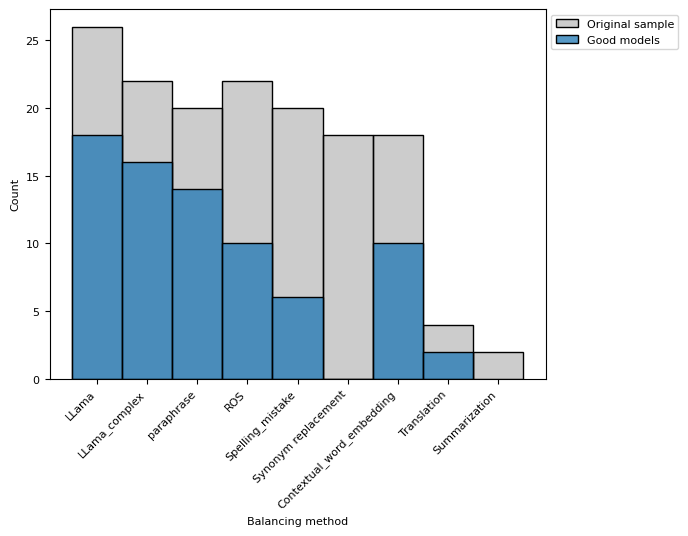

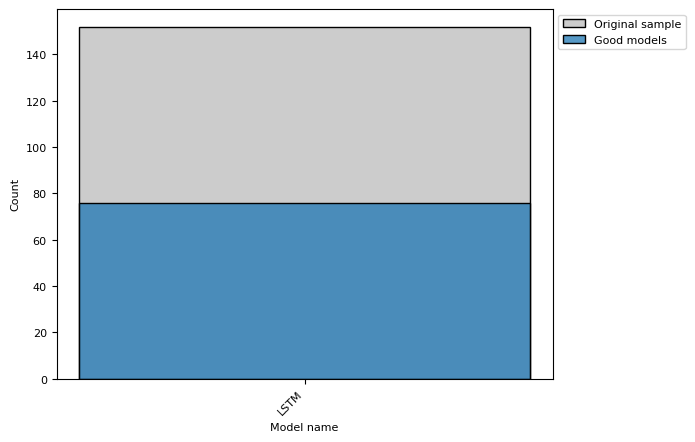

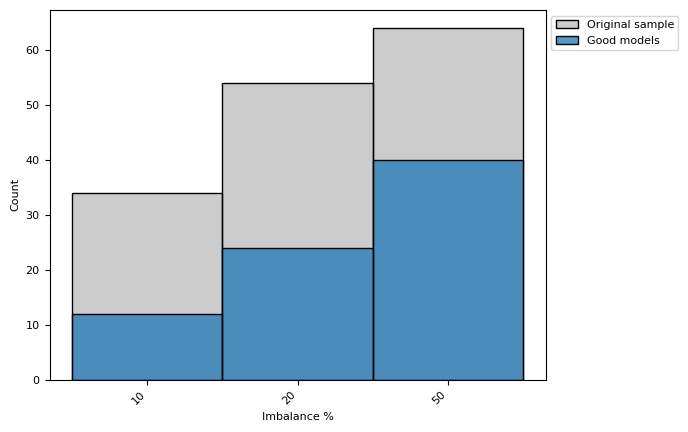

In [14]:
for dimension in ["Balancing method", "Model name", "Imbalance %"]:
    sns.histplot(final_word[dimension].astype(str),color="gray", alpha=.4, label="Original sample")
    metrics_temp = final_word[final_word.f1>=threshold]
    g=sns.histplot(metrics_temp[dimension].astype(str),label="Good models")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    sns.move_legend(g, "upper left", bbox_to_anchor=(1,1))
    plt.savefig(out+"\\"+f"removal_of_bad_xai_{model_name}_{dimension.split(' ')[0]}.png", bbox_inches='tight')
    plt.show()

# Are balanced models more similar to original or imbalanced model?

### Sentence

In [15]:
print("Sentence")
similarity_balanced_imbalanced(final_sentence, threshold)
print("Word")
similarity_balanced_imbalanced(final_word, threshold)

Sentence


,mean good,median good,rejection rate good,mean bad,median bad,rejection rate bad
original,0.2368,0.0389,0.5132,0.3099,0.2287,0.3684
imbalanced,0.0801,0.0002,0.8026,0.1150,0.0012,0.7500


\begin{tabular}{|lllllll|}\hline
  & mean good & median good & rejection rate good & mean bad & median bad & rejection rate bad \\\hline
original & 0.2368 & 0.0389 & 0.5132 & 0.3099 & 0.2287 & 0.3684 \\
imbalanced & 0.0801 & 0.0002 & 0.8026 & 0.115 & 0.0012 & 0.75 \\\hline
\end{tabular}

Word


,mean good,median good,rejection rate good,mean bad,median bad,rejection rate bad
original,0.4058,0.3307,0.0263,0.3558,0.2778,0.0263
imbalanced,0.3681,0.2431,0.2566,0.4499,0.4614,0.2105


\begin{tabular}{|lllllll|}\hline
  & mean good & median good & rejection rate good & mean bad & median bad & rejection rate bad \\\hline
original & 0.4058 & 0.3307 & 0.0263 & 0.3558 & 0.2778 & 0.0263 \\
imbalanced & 0.3681 & 0.2431 & 0.2566 & 0.4499 & 0.4614 & 0.2105 \\\hline
\end{tabular}



### Spearman

In [16]:
print("Sentence")
display(similarity_balanced_imbalanced(final_sentence, threshold, spearman = True))
print("Word")
similarity_balanced_imbalanced(final_word, threshold, spearman = True)

Sentence


,mean good,median good,mean bad,median bad
spearman_original,0.6133,0.5866,0.5626,0.5204
spearman_imbalanced,0.6520,0.6644,0.6071,0.5912


\begin{tabular}{|lllll|}\hline
  & mean good & median good & mean bad & median bad \\\hline
spearman\_original & 0.6133 & 0.5866 & 0.5626 & 0.5204 \\
spearman\_imbalanced & 0.652 & 0.6644 & 0.6071 & 0.5912 \\\hline
\end{tabular}



None

Word


,mean good,median good,mean bad,median bad
spearman_original,0.5932,0.5850,0.5455,0.5309
spearman_imbalanced,0.6608,0.6697,0.6208,0.6259


\begin{tabular}{|lllll|}\hline
  & mean good & median good & mean bad & median bad \\\hline
spearman\_original & 0.5932 & 0.585 & 0.5455 & 0.5309 \\
spearman\_imbalanced & 0.6608 & 0.6697 & 0.6208 & 0.6259 \\\hline
\end{tabular}



# Which method results in models the most similar to original model?

In [17]:
print("Sentence")
similarity_balancing_methods(final_sentence, threshold)
print("Word")
similarity_balancing_methods(final_word, threshold)

Sentence


,mean good,median good,rejection rate good,mean bad,median bad,rejection rate bad
Balancing method,,,,,,
Contextual_word_embedding,0.2128,0.0696,0.5000,0.4508,0.2592,0.0000
LLama,0.1010,0.0004,0.8333,0.0023,0.0003,1.0000
LLama_complex,0.0942,0.0004,0.8750,0.0043,0.0004,1.0000
ROS,0.3438,0.2312,0.2000,0.4429,0.3440,0.0833
Spelling_mistake,0.5099,0.5132,0.0000,0.3187,0.2536,0.3571
Translation,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
paraphrase,0.0356,0.0001,0.8571,0.3408,0.2587,0.3333
Summarization,NaN,NaN,NaN,0.0000,0.0000,1.0000
Synonym replacement,NaN,NaN,NaN,0.4489,0.2974,0.1111


\begin{tabular}{|l|lll|lll|}\hline
Balancing method &  \multicolumn{3}{|c|}{$>80\%$ f1}   &   \multicolumn{3}{|c|}{$\leq80\%$ f1}  \\
  & mean  & median  & rejection rate  & mean  & median  & rejection rate  \\\hline
Contextual\_word\_embedding & 0.2128 & 0.0696 & 0.5 & 0.4508 & 0.2592 & 0.0 \\
LLama & 0.101 & 0.0004 & 0.8333 & 0.0023 & 0.0003 & 1.0 \\
LLama\_complex & 0.0942 & 0.0004 & 0.875 & 0.0043 & 0.0004 & 1.0 \\
ROS & 0.3438 & 0.2312 & 0.2 & 0.4429 & 0.344 & 0.0833 \\
Spelling\_mistake & 0.5099 & 0.5132 & 0.0 & 0.3187 & 0.2536 & 0.3571 \\
Translation & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 1.0 \\
paraphrase & 0.0356 & 0.0001 & 0.8571 & 0.3408 & 0.2587 & 0.3333 \\
Summarization & nan & nan & nan & 0.0 & 0.0 & 1.0 \\
Synonym replacement & nan & nan & nan & 0.4489 & 0.2974 & 0.1111 \\\hline
\end{tabular}

Word


,mean good,median good,rejection rate good,mean bad,median bad,rejection rate bad
Balancing method,,,,,,
Contextual_word_embedding,0.4374,0.3549,0.1000,0.2794,0.2079,0.125
LLama,0.4865,0.5277,0.0556,0.6117,0.5664,0.000
LLama_complex,0.5340,0.5816,0.0000,0.5112,0.4543,0.000
ROS,0.3494,0.2695,0.0000,0.3494,0.2312,0.000
Spelling_mistake,0.3047,0.1774,0.0000,0.3590,0.3002,0.000
Translation,0.1528,0.1528,0.0000,0.1162,0.1162,0.500
paraphrase,0.5246,0.4390,0.0000,0.3755,0.3235,0.000
Summarization,NaN,NaN,NaN,0.1118,0.1118,0.000
Synonym replacement,NaN,NaN,NaN,0.2730,0.2606,0.000


\begin{tabular}{|l|lll|lll|}\hline
Balancing method &  \multicolumn{3}{|c|}{$>80\%$ f1}   &   \multicolumn{3}{|c|}{$\leq80\%$ f1}  \\
  & mean  & median  & rejection rate  & mean  & median  & rejection rate  \\\hline
Contextual\_word\_embedding & 0.4374 & 0.3549 & 0.1 & 0.2794 & 0.2079 & 0.125 \\
LLama & 0.4865 & 0.5277 & 0.0556 & 0.6117 & 0.5664 & 0.0 \\
LLama\_complex & 0.534 & 0.5816 & 0.0 & 0.5112 & 0.4543 & 0.0 \\
ROS & 0.3494 & 0.2695 & 0.0 & 0.3494 & 0.2312 & 0.0 \\
Spelling\_mistake & 0.3047 & 0.1774 & 0.0 & 0.359 & 0.3002 & 0.0 \\
Translation & 0.1528 & 0.1528 & 0.0 & 0.1162 & 0.1162 & 0.5 \\
paraphrase & 0.5246 & 0.439 & 0.0 & 0.3755 & 0.3235 & 0.0 \\
Summarization & nan & nan & nan & 0.1118 & 0.1118 & 0.0 \\
Synonym replacement & nan & nan & nan & 0.273 & 0.2606 & 0.0 \\\hline
\end{tabular}



### Spearman

In [18]:
print("Sentence")
display(similarity_balancing_methods(final_sentence, threshold, spearman = True))
print("Word")
similarity_balancing_methods(final_word, threshold, spearman = True)

Sentence


,mean good,median good,mean bad,median bad
Balancing method,,,,
Contextual_word_embedding,0.6246,0.6857,0.6078,0.5085
LLama,0.7663,0.7510,0.5561,0.4856
LLama_complex,0.7885,0.8789,0.5005,0.4464
ROS,0.5935,0.6210,0.6615,0.6758
Spelling_mistake,0.5276,0.4869,0.6754,0.6410
Translation,0.5360,0.5360,0.5189,0.5189
paraphrase,0.5453,0.6114,0.2478,0.2603
Summarization,NaN,NaN,0.4698,0.4698
Synonym replacement,NaN,NaN,0.5327,0.5343


\begin{tabular}{|lllll|}\hline
Balancing method & mean good & median good & mean bad & median bad \\\hline
Contextual\_word\_embedding & 0.6246 & 0.6857 & 0.6078 & 0.5085 \\
LLama & 0.7663 & 0.751 & 0.5561 & 0.4856 \\
LLama\_complex & 0.7885 & 0.8789 & 0.5005 & 0.4464 \\
ROS & 0.5935 & 0.621 & 0.6615 & 0.6758 \\
Spelling\_mistake & 0.5276 & 0.4869 & 0.6754 & 0.641 \\
Translation & 0.536 & 0.536 & 0.5189 & 0.5189 \\
paraphrase & 0.5453 & 0.6114 & 0.2478 & 0.2603 \\
Summarization & nan & nan & 0.4698 & 0.4698 \\
Synonym replacement & nan & nan & 0.5327 & 0.5343 \\\hline
\end{tabular}



None

Word


,mean good,median good,mean bad,median bad
Balancing method,,,,
Contextual_word_embedding,0.6146,0.6988,0.5859,0.5566
LLama,0.6935,0.6671,0.5480,0.5150
LLama_complex,0.7411,0.8375,0.4544,0.4477
ROS,0.5362,0.5511,0.6516,0.6844
Spelling_mistake,0.5149,0.5311,0.6120,0.5807
Translation,0.6617,0.6617,0.6449,0.6449
paraphrase,0.6033,0.7363,0.2498,0.2799
Summarization,NaN,NaN,0.6301,0.6301
Synonym replacement,NaN,NaN,0.5123,0.5175


\begin{tabular}{|lllll|}\hline
Balancing method & mean good & median good & mean bad & median bad \\\hline
Contextual\_word\_embedding & 0.6146 & 0.6988 & 0.5859 & 0.5566 \\
LLama & 0.6935 & 0.6671 & 0.548 & 0.515 \\
LLama\_complex & 0.7411 & 0.8375 & 0.4544 & 0.4477 \\
ROS & 0.5362 & 0.5511 & 0.6516 & 0.6844 \\
Spelling\_mistake & 0.5149 & 0.5311 & 0.612 & 0.5807 \\
Translation & 0.6617 & 0.6617 & 0.6449 & 0.6449 \\
paraphrase & 0.6033 & 0.7363 & 0.2498 & 0.2799 \\
Summarization & nan & nan & 0.6301 & 0.6301 \\
Synonym replacement & nan & nan & 0.5123 & 0.5175 \\\hline
\end{tabular}

